### Plot Location Pickles Results and Compare with Heatmaps

Mount and import the needed libraries

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
%cd /content/gdrive/MyDrive/grapes_project/samples/uvas

/content/gdrive/MyDrive/grapes_project/samples/uvas


In [ ]:
from google.colab.patches import cv2_imshow
import cv2
import pandas as pd
import os
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import ListedColormap, BoundaryNorm
from heat_map_generation.count_heatMap import create_frame_intervals


### Create Mega Pickle

In [ ]:
!python utils/create_mega_pickle.py --pickles_dir stuff/pickles/dcomplete_pgrapes_aug/

Saving data frame to mega pickle...
  CAMPO_ID  ... RACIMO_AREA
0        2  ...       42575
1        2  ...       25047
2        2  ...       20085
3        2  ...       45045
4        2  ...       30191

[5 rows x 6 columns]


### Group by cuartel and campo

In [ ]:
!python utils/group_by_cuartel.py --locations_dir=stuff/pickles/dcomplete_pgrapes_aug/location_pickles/


Location dir: stuff/pickles/dcomplete_pgrapes_aug/location_pickles/


In [ ]:
!mkdir stuff/pickles/dcomplete_pgrapes_aug/location_pickles/campo1
!mkdir stuff/pickles/dcomplete_pgrapes_aug/location_pickles/campo2

In [ ]:
!mv stuff/pickles/dcomplete_pgrapes_aug/location_pickles/cuartel_1_* stuff/pickles/dcomplete_pgrapes_aug/location_pickles/campo1

In [ ]:
!mv stuff/pickles/dcomplete_pgrapes_aug/location_pickles/cuartel_2_* stuff/pickles/dcomplete_pgrapes_aug/location_pickles/campo2

### Create HeatMap

In [ ]:
!python heat_map_generation/generate_heatmaps.py \
          --campo stuff/pickles/dcomplete_pgrapes_aug/location_pickles/campo1 \
          --img stuff/satellite_images/campo1.jpg  \
          --megapk stuff/pickles/dcomplete_pgrapes_aug/mega_pickle.pkl \
          --sat_info stuff/json/ConchayToro.json \
          --campo_name ConchaYToro_Campo1


stuff/pickles/dcomplete_pgrapes_aug/mega_pickle.pkl
       CAMPO_ID  ... RACIMO_AREA
0             2  ...       42575
1             2  ...       25047
2             2  ...       20085
3             2  ...       45045
4             2  ...       30191
...         ...  ...         ...
123195        1  ...        4560
123196        1  ...       10624
123197        1  ...        2668
123198        1  ...       15330
123199        1  ...        2623

[123200 rows x 6 columns]


Show heatmap result image

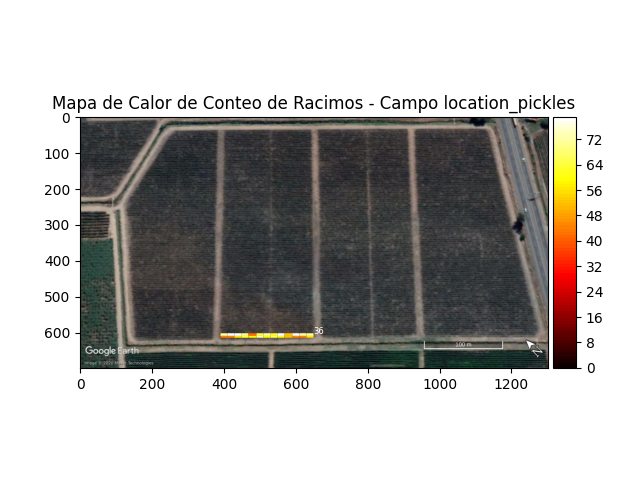

In [ ]:
img = cv2.imread("stuff/heat_maps/location_pickles.png")
cv2_imshow(img)

Show the sample result

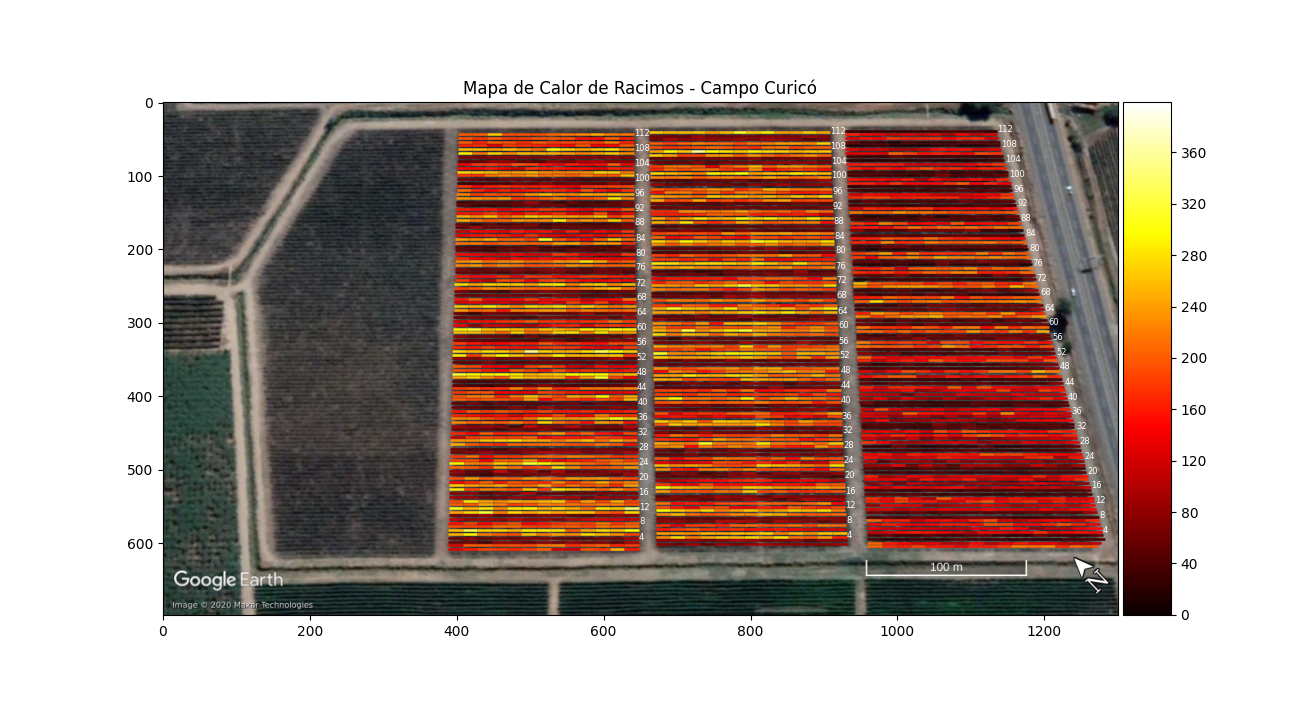

In [ ]:
img = cv2.imread("heat_map_generation/heatMaps/heatMapCurico.png")
cv2_imshow(img)

### Group by Frame Count and Ploting detection by frames

Create a function to transform the location pickles to a data frame

In [ ]:
def location_pickle_to_df(file_name):
    #get the hilera id
    n_hilera = file_name.split("_")[1]
    
    #Read the pickle as dict
    df = pd.read_pickle(os.path.join(PICKLE_DIR,file_name))
    
    #Transform to pickle to dataframe
    df = pd.DataFrame(df.items(), columns=['id_racimo', 'info_racimo'])
    df['hilera_id'] = n_hilera
    
    #Split the info racimo and concat in a new data frame
    tmp = pd.DataFrame(df['info_racimo'].tolist(), index=df.index, columns=['frame_count','x_center','distance'])
    df = pd.concat([df['hilera_id'],df['id_racimo'],tmp],axis=1)
    
    return df

Load the am and pm location pickles of the same "hilera" and get the detection per frame

In [ ]:
PICKLE_DIR = "/content/gdrive/MyDrive/grapes_project/samples/uvas/stuff/pickles/dcompleto_pgrapes/location_pickles/cuartel_2_2/"
file_name = "locations_2_2_36_1.pkl"
df_am = location_pickle_to_df(file_name)

file_name = "locations_2_2_36_2.pkl"
df_pm = location_pickle_to_df(file_name)

df = pd.concat([df_am, df_pm])

# Transform to detection per frame
df['detections'] = 1
df = df[['frame_count', 'detections']]
df = df.groupby("frame_count").sum().reset_index()
df

,frame_count,detections
0,7,2
1,23,1
2,47,1
3,87,1
4,95,1
...,...,...
586,9151,1
587,9175,1
588,9199,1
589,9215,1


Plot the detection per frame of both am and pm at the same time.

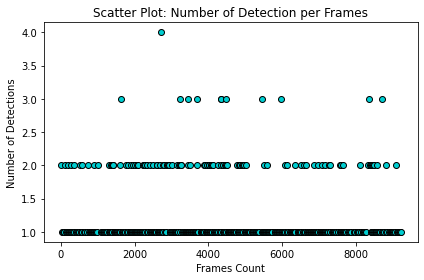

In [ ]:
num_bins = 120
x = list(df['frame_count'])
y = list(df['detections'])

fig, ax = plt.subplots()

ax.scatter(x,y,color = 'darkturquoise', edgecolor = 'black')
ax.set_xlabel('Frames Count')
ax.set_ylabel('Number of Detections')
ax.set_title(r'Scatter Plot: Number of Detection per Frames')

# Tweak spacing to prevent clipping of ylabel
fig.tight_layout()
plt.show()

### Define variables and load data

In [ ]:
PICKLE_DIR = "/content/gdrive/MyDrive/grapes_project/samples/uvas/stuff/pickles/dcompleto_pgrapes/location_pickles/cuartel_2_2/"
file_name = "locations_2_2_36_1.pkl"
df_am = location_pickle_to_df(file_name)

file_name = "locations_2_2_36_2.pkl"
df_pm = location_pickle_to_df(file_name)

In [ ]:
data_frames = [df_am, df_pm]
n_intervals = 13

accu_counts = np.zeros(n_intervals)

# Count the amount of bunches per segment in a hilera
# This execute for am and pm information
for df_sample in data_frames:

  frames = np.array(df_sample['frame_count'])

  start_frame = np.amin(frames)
  end_frame = np.amax(frames)

  frame_bins = create_frame_intervals(start_frame,end_frame,n_intervals)

  counts,_ = np.histogram(frames,bins=frame_bins)
  accu_counts += counts
  print(frame_bins)

print(accu_counts)

[7.000e+00 7.150e+02 1.423e+03 2.131e+03 2.839e+03 3.547e+03 4.255e+03
 4.963e+03 5.671e+03 6.379e+03 7.087e+03 7.795e+03 8.503e+03 9.223e+03]
[7.000e+00 6.000e+02 1.193e+03 1.786e+03 2.379e+03 2.972e+03 3.565e+03
 4.158e+03 4.751e+03 5.344e+03 5.937e+03 6.530e+03 7.123e+03 7.719e+03]
[44. 44. 56. 63. 58. 71. 59. 65. 59. 51. 45. 44. 56.]


### Plot the detection per segmen using a cmap

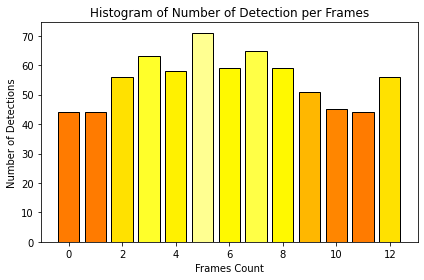

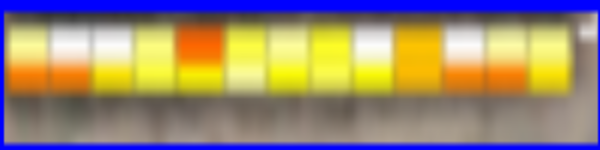

In [ ]:
num_bins = 13
x = [i for i in range(num_bins)]

fig, ax = plt.subplots()

TOP_BOUNDARY_COUNT = 80
#color map and norm definition
cmap = plt.cm.get_cmap('hot', 256)

# the histogram of the data
containers = ax.bar(x,accu_counts, edgecolor = 'black')

# scale values to interval [0,1]
col = accu_counts / TOP_BOUNDARY_COUNT

# apply color according to the number of detections
for c, p in zip(col, containers):
    plt.setp(p, 'facecolor', cmap(c))

ax.set_xlabel('Frames Count')
ax.set_ylabel('Number of Detections')
ax.set_title(r'Histogram of Number of Detection per Frames')

# Tweak spacing to prevent clipping of ylabel
fig.tight_layout()
plt.show()

# Show the lines that are plotted in the satellitel image
x, y = (665,745)
w, h = (300,25)
img = cv2.imread("stuff/heat_maps/location_pickles.png")
img = cv2.resize(img, (1940,1080))
img = cv2.rectangle(img, (x,y), (x+w,y+h), (255, 0, 0) , 2) 

crop_img = img[y:y+h, x:x+w]
crop_img = cv2.resize(crop_img, (600,150))
cv2_imshow(crop_img)

Locate the hilera that we can show

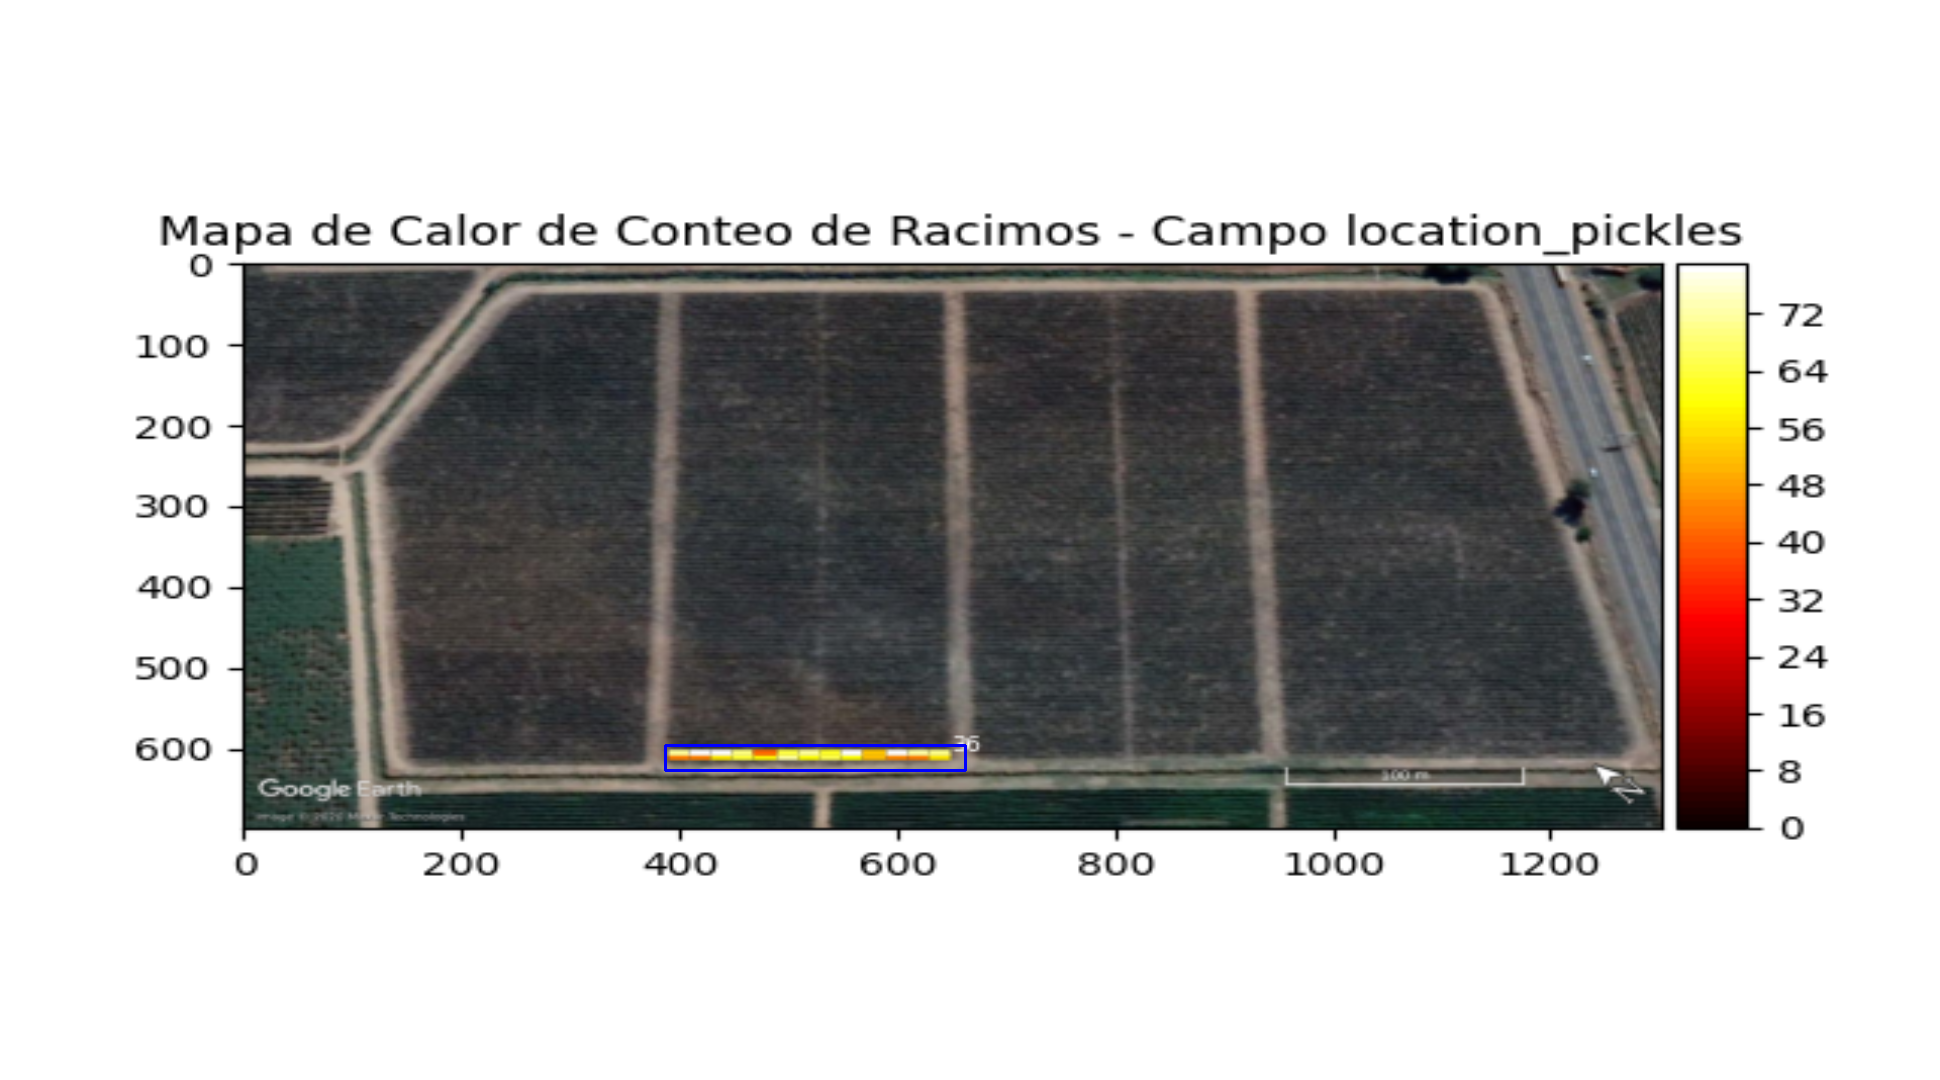

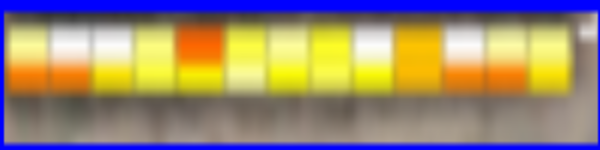

In [ ]:
x, y = (665,745)
w, h = (300,25)
img = cv2.imread("stuff/heat_maps/location_pickles.png")
img = cv2.resize(img, (1940,1080))
img = cv2.rectangle(img, (x,y), (x+w,y+h), (255, 0, 0) , 2) 

crop_img = img[y:y+h, x:x+w]
crop_img = cv2.resize(crop_img, (600,150))
cv2_imshow(img)
cv2_imshow(crop_img)

Plot histograms in another way, divide the detection per intervals according to num_bins. This is a uniform division in comparison with the previous one that was based on min and max frames.

[44. 48. 60. 64. 66. 70. 74. 52. 46. 55. 49. 43. 44.]


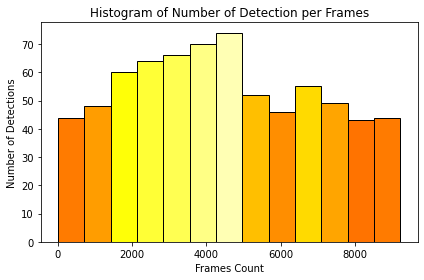

In [ ]:
num_bins = 13
x = list(df['frame_count'])

fig, ax = plt.subplots()

TOP_BOUNDARY_COUNT = 80
#color map and norm definition
cmap = plt.cm.get_cmap('hot', 256)

# the histogram of the data
n, bins, patches = ax.hist(x, num_bins, edgecolor = 'black') #, color = 'darkturquoise')

print(n)
bin_centers = 0.5 * (bins[:-1] + bins[1:])

# scale values to interval [0,1]
col = n / TOP_BOUNDARY_COUNT

for c, p in zip(col, patches):
    plt.setp(p, 'facecolor', cmap(c))

ax.set_xlabel('Frames Count')
ax.set_ylabel('Number of Detections')
ax.set_title(r'Histogram of Number of Detection per Frames')

# Tweak spacing to prevent clipping of ylabel
fig.tight_layout()
plt.show()